# Transformer Pre-processing
## Ungraded => Understanding positional encoding

Welcome to Week 4's first ungraded lab. In this notebook you will delve into the pre-processing methods you apply to raw text to before passing it to the encoder and decoder blocks of the transformer architecture. 

**After this assignment you'll be able to**:

* Create visualizations to gain intuition on positional encodings
* Visualize how positional encodings affect word embeddings


## Table of Contents

- [Packages](#0)
- [1 - Positional Encoding](#1)
    - [1.1 - Positional encoding visualizations](#1-1)
    - [1.2 - Comparing positional encodings](#1-2)   
- [2 - Semantic embedding](#2)
    - [2.1 - Load pretrained embedding](#2-1)
    - [2.2 - Visualization on a Cartesian plane](#2-2)
- [3 - Semantic and positional embedding](#3)

<a name='0'></a>
## Packages

Run the following cell to load the packages you'll need.

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

<a name='1'></a>
## 1 - Positional Encoding

Here are the positional encoding equations that you implemented in the previous assignment. This encoding uses the following formulas:

$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$
<br>

$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$

<a name='ex-2'></a>


It is a standard practice in natural language processing tasks to convert sentences into tokens before feeding texts into a language model. Each token is then converted into a numerical vector of fixed length called an embedding, which captures the meaning of the words. In the Transformer architecture, a positional encoding vector is added to the embedding to pass positional information throughout the model. 

The meaning of these vectors can be difficult to grasp solely by examining the numerical representations, but visualizations can help give some intuition as to the semantic and positional similarity of the words. As you've seen in previous assignments, when embeddings are reduced to two dimensions and plotted, semantically similar words appear closer together, while dissimilar words are plotted farther apart. A similar exercise can be performed with positional encoding vectors - words that are closer in a sentence should appear closer when plotted on a Cartesian plane, and when farther in a sentence, should appear farther on the plane. 

In this notebook, you will create a series of visualizations of word embeddings and positional encoding vectors to gain intuition into how positional encodings affect word embeddings and help transport sequential information through the Transformer architecture.  
    



<a name='1-1'></a>
### 1.1 - Positional encoding visualizations

The following code cell has the `positional_encoding` function which you implemented in the Transformer assignment. Nice work! You will build off that work to create some more visualizations with this function in this notebook.

In [7]:
a=np.arange(10)[np.newaxis]*2
a= (2 * (np.arange(10)[np.newaxis, :]//2))
a, a+1

(array([[0, 0, 2, 2, 4, 4, 6, 6, 8, 8]]),
 array([[1, 1, 3, 3, 5, 5, 7, 7, 9, 9]]))

In [2]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """

    # initialize a matrix angle_rads of all the angles 
    angle_rads = np.arange(positions)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d)[np.newaxis, :]//2)) / np.float32(d))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

Define the embedding dimension as 100. This value must match the dimensionality of the word embedding. In the ["Attention is All You Need"](https://arxiv.org/abs/1706.03762) paper, embedding sizes range from 100 to 1024, depending on the task. The authors also use a maximum sequence length ranging from 40 to 512 depending on the task. Define the maximum sequence length to be 100, and the maximum number of words to be 64. 

In [11]:
pos_encoding.shape

TensorShape([1, 100, 100])

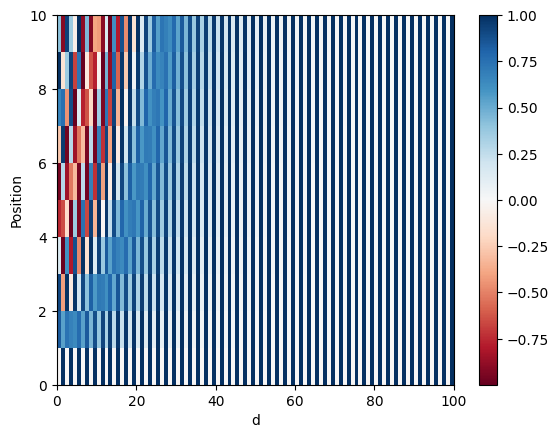

In [14]:
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 64
pos_encoding = positional_encoding(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)

#plt.pcolormesh(pos_encoding[0][0:10], cmap='RdBu')
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, EMBEDDING_DIM))
plt.ylabel('Position')
plt.colorbar()
plt.show()

You have already created this visualization in this assignment, but let us dive a little deeper. Notice some interesting properties of the matrix - the first is that the norm of each of the vectors is always a constant. No matter what the value of `pos` is, the norm will always be the same value, which in this case is 7.071068. From this property you can conclude that the dot product of two positional encoding vectors is not affected by the scale of the vector, which has important implications for correlation calculations. 

In [27]:
"3 or 34 => ", tf.norm(pos_encoding[0,3,:]), bool(tf.norm(pos_encoding[0,3,:]) == tf.norm(pos_encoding[0,34,:]))

('3 or 34 => ', <tf.Tensor: shape=(), dtype=float32, numpy=7.071068>, True)

Another interesting property is that the norm of the difference between 2 vectors separated by `k` positions is also constant. If you keep `k` constant and change `pos`, the difference will be of approximately the same value. This property is important because it demonstrates that the difference does not depend on the positions of each encoding, but rather the relative seperation between encodings. Being able to express positional encodings as linear functions of one another can help the model to learn by focusing on the relative positions of words.

This reflection of the difference in the positions of words with vector encodings is difficult to achieve, especially given that the values of the vector encodings must remain small enough so that they do not distort the word embeddings. 

In [ ]:
pos = 70
k = 2
print(tf.norm(pos_encoding[0,pos,:] -  pos_encoding[0,pos + k,:]))

You have observed some interesting properties about the positional encoding vectors - next, you will create some visualizations to see how these properties affect the relationships between encodings and embeddings!

<a name='1-2'></a>
### 1.2 - Comparing positional encodings

#### 1.2.1 - Correlation

The positional encoding matrix help to visualize how each vector is unique for every position. However, it is still not clear how these vectors can represent the relative position of the words in a sentence. To illustrate this, you will calculate the correlation between pairs of vectors at every single position. A successful positional encoder will produce a perfectly symmetric matrix in which maximum values are located at the main diagonal - vectors in similar positions should have the highest correlation. Following the same logic, the correlation values should get smaller as they move away from the main diagonal.


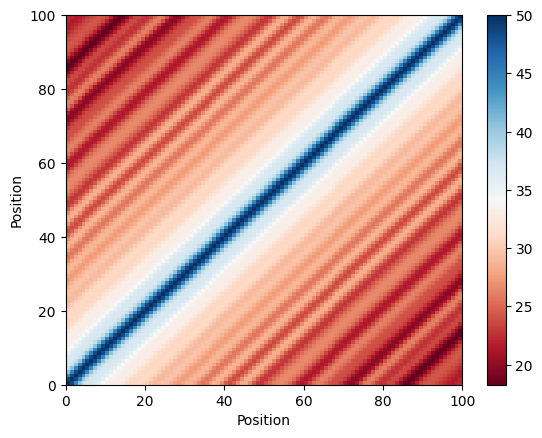

In [28]:
# Positional encoding correlation
corr = tf.matmul(pos_encoding, pos_encoding, transpose_b=True).numpy()[0]
plt.pcolormesh(corr, cmap='RdBu')
plt.xlabel('Position')
plt.xlim((0, MAX_SEQUENCE_LENGTH))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### 1.2.2 - Euclidean distance

You can also use the euclidean distance instead of the correlation for comparing the positional encoding vectors. In this case, your visualization will display a matrix in which the main diagonal is 0, and its off-diagonal values increase as they move away from the main diagonal.


(100, 100)


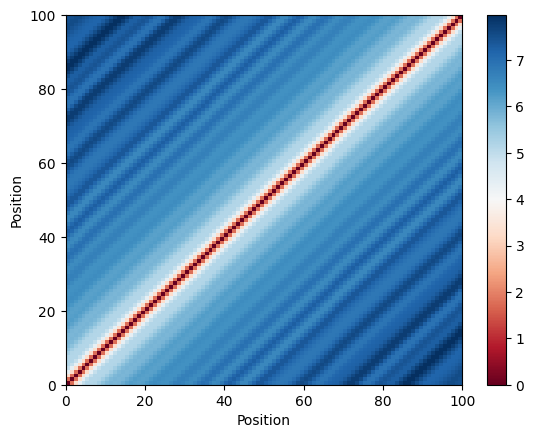

In [29]:
# Positional encoding euclidean distance
eu = np.zeros((MAX_SEQUENCE_LENGTH, MAX_SEQUENCE_LENGTH))
print(eu.shape)
for a in range(MAX_SEQUENCE_LENGTH):
    for b in range(a + 1, MAX_SEQUENCE_LENGTH):
        eu[a, b] = tf.norm(tf.math.subtract(pos_encoding[0, a], pos_encoding[0, b]))
        eu[b, a] = eu[a, b]
        
plt.pcolormesh(eu, cmap='RdBu')
plt.xlabel('Position')
plt.xlim((0, MAX_SEQUENCE_LENGTH))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Nice work! You can use these visualizations as checks for any positional encodings you create. 

<a name='2'></a>
## 2 - Semantic embedding

You have gained insight into the relationship positional encoding vectors have with other vectors at different positions by creating correlation and distance matrices. Similarly, you can gain a stronger intuition as to how positional encodings affect word embeddings by visualizing the sum of these vectors.  


<a name='2-1'></a>
### 2.1 - Load pretrained embedding

To combine a pretrained word embedding with the positional encodings you created, start by loading one of the pretrained embeddings from the [glove](https://nlp.stanford.edu/projects/glove/) project. You will use the embedding with 100 features. 

In [31]:
embeddings_index = {}
GLOVE_DIR = "glove"
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print('d_model: %s', embeddings_index['hi'].shape)

Found 400000 word vectors.
d_model: %s (100,)


**Note:** This embedding is composed of 400,000 words and each word embedding has 100 features.

Consider the following text that only contains two sentences. Wait a minute - these sentences have no meaning! Instead, the sentences are engineered such that:
* Each sentence is composed of sets of words, which have some semantic similarities among each groups.
* In the first sentence similar terms are consecutive, while in the second sentence, the order is random. 

In [33]:
texts = ['king queen man woman dog wolf football basketball red green yellow',
         'man queen yellow basketball green dog  woman football  king red wolf']

First, run the following code cell to apply the tokenization to the raw text. Don't worry too much about what this step does - it will be explained in detail in later ungraded labs. A quick summary (not crucial to understanding the lab):

* If you feed an array of plain text of different sentence lengths, and it will produce a matrix with one row for each sentence, each of them represented by an array of size `MAX_SEQUENCE_LENGTH`.
* Each value in this array represents each word of the sentence using its corresponding index in a dictionary(`word_index`). 
* The sequences shorter than the `MAX_SEQUENCE_LENGTH` are padded with zeros to create uniform length. 

Again, this is explained in detail in later ungraded labs, so don't worry about this too much right now!

In [34]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

print(data.shape)

print(data)

Found 11 unique tokens.
(2, 100)
[[ 1  2  3  4  5  6  7  8  9 10 11  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 3  2 11  8 10  5  4  7  1  9  6  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]


To simplify your model, you will only need to obtain the embeddings for the different words that appear in the text you are examining. In this case, you will filter out only the 11 words appearing in our sentences. The first vector will be an array of zeros and will codify all the unknown words.

In [63]:
word_index, len(embeddings_index), embeddings_index['king']

({'king': 1,
  'queen': 2,
  'man': 3,
  'woman': 4,
  'dog': 5,
  'wolf': 6,
  'football': 7,
  'basketball': 8,
  'red': 9,
  'green': 10,
  'yellow': 11},
 400000,
 array([-0.32307 , -0.87616 ,  0.21977 ,  0.25268 ,  0.22976 ,  0.7388  ,
        -0.37954 , -0.35307 , -0.84369 , -1.1113  , -0.30266 ,  0.33178 ,
        -0.25113 ,  0.30448 , -0.077491, -0.89815 ,  0.092496, -1.1407  ,
        -0.58324 ,  0.66869 , -0.23122 , -0.95855 ,  0.28262 , -0.078848,
         0.75315 ,  0.26584 ,  0.3422  , -0.33949 ,  0.95608 ,  0.065641,
         0.45747 ,  0.39835 ,  0.57965 ,  0.39267 , -0.21851 ,  0.58795 ,
        -0.55999 ,  0.63368 , -0.043983, -0.68731 , -0.37841 ,  0.38026 ,
         0.61641 , -0.88269 , -0.12346 , -0.37928 , -0.38318 ,  0.23868 ,
         0.6685  , -0.43321 , -0.11065 ,  0.081723,  1.1569  ,  0.78958 ,
        -0.21223 , -2.3211  , -0.67806 ,  0.44561 ,  0.65707 ,  0.1045  ,
         0.46217 ,  0.19912 ,  0.25802 ,  0.057194,  0.53443 , -0.43133 ,
        -0.34311 , 

In [67]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    print(word, i)
print(embedding_matrix.shape), embedding_matrix

king 1
queen 2
man 3
woman 4
dog 5
wolf 6
football 7
basketball 8
red 9
green 10
yellow 11
(12, 100)


(None,
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.32306999, -0.87616003,  0.21977   , ..., -0.52881002,
          0.16483   , -0.98878002],
        [-0.50045002, -0.70826   ,  0.55387998, ..., -0.36032   ,
          0.13347   , -0.56075001],
        ...,
        [-0.30017   ,  0.50145   , -0.12752999, ...,  0.17312001,
          0.12926   , -0.48525   ],
        [-0.67907   ,  0.34908   , -0.23984   , ...,  0.1296    ,
          0.18388   , -0.030383  ],
        [ 0.0099457 ,  0.34376001, -0.21357   , ...,  0.022348  ,
         -0.32367   , -0.64086002]]))

Create an embedding layer using the weights extracted from the pretrained glove embeddings.

In [39]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            trainable=False)

Transform the input tokenized data to the embedding using the previous layer. Check the shape of the embedding to make sure the last dimension of this matrix contains the embeddings of the words in the sentence. 

In [68]:
embedding = embedding_layer(data)
print(embedding.shape)
embedding[0, 0]

(2, 100, 100)


<a name='2-2'></a>
### 2.2 - Visualization on a Cartesian plane

Now, you will create a function that allows you to visualize the encoding of our words in a Cartesian plane. You will use PCA to reduce the 100 features of the glove embedding to only 2 components. 

In [41]:
from sklearn.decomposition import PCA

def plot_words(embedding, sequences, sentence):
    pca = PCA(n_components=2)
    X_pca_train = pca.fit_transform(embedding[sentence,0:len(sequences[sentence]),:])


    fig, ax = plt.subplots(figsize=(12, 6)) 
    plt.rcParams['font.size'] = '12'
    ax.scatter(X_pca_train[:, 0], X_pca_train[:, 1])
    words = list(word_index.keys())
    for i, index in enumerate(sequences[sentence]):
        ax.annotate(words[index-1], (X_pca_train[i, 0], X_pca_train[i, 1]))


Nice! Now you can plot the embedding of each of the sentences. Each plot should disply the embeddings of the different words. 


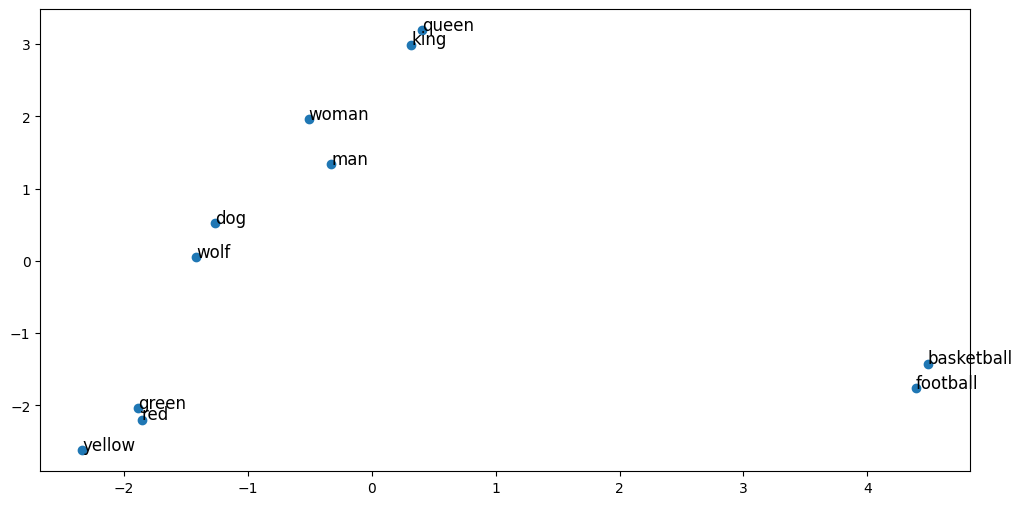

In [42]:
plot_words(embedding, sequences, 0)

Plot the word of embeddings of the second sentence. Recall that the second sentence contains the same words are the first sentence, just in a different order. You can see that the order of the words does not affect the vector representations. 

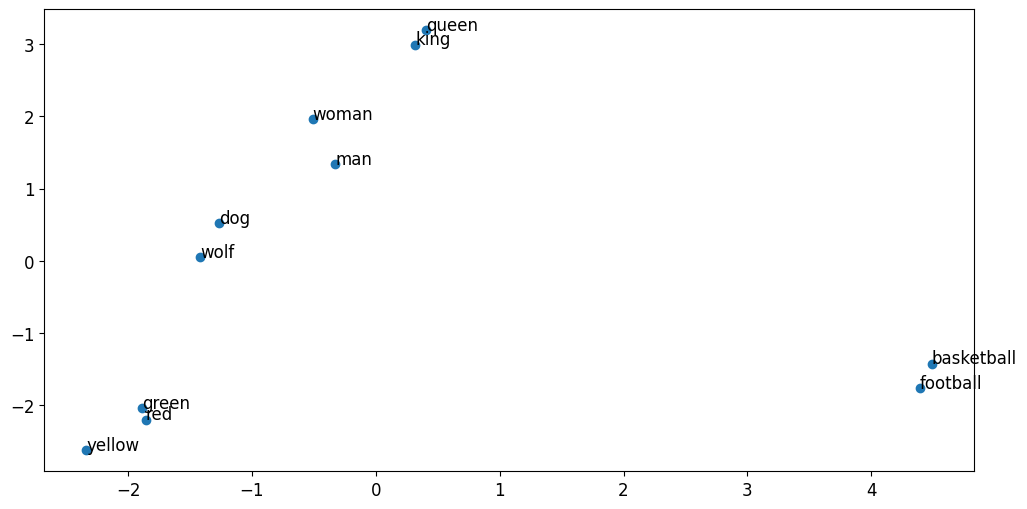

In [43]:
plot_words(embedding, sequences, 1)

<a name='3'></a>
## 3 - Semantic and positional embedding

Next, you will combine the original glove embedding with the positional encoding you calculated earlier. For this exercise, you will use a 1 to 1 weight ratio between the semantic and the positional embedding. 

['king queen man woman dog wolf football basketball red green yellow',
 'man queen yellow basketball green dog  woman football  king red wolf']

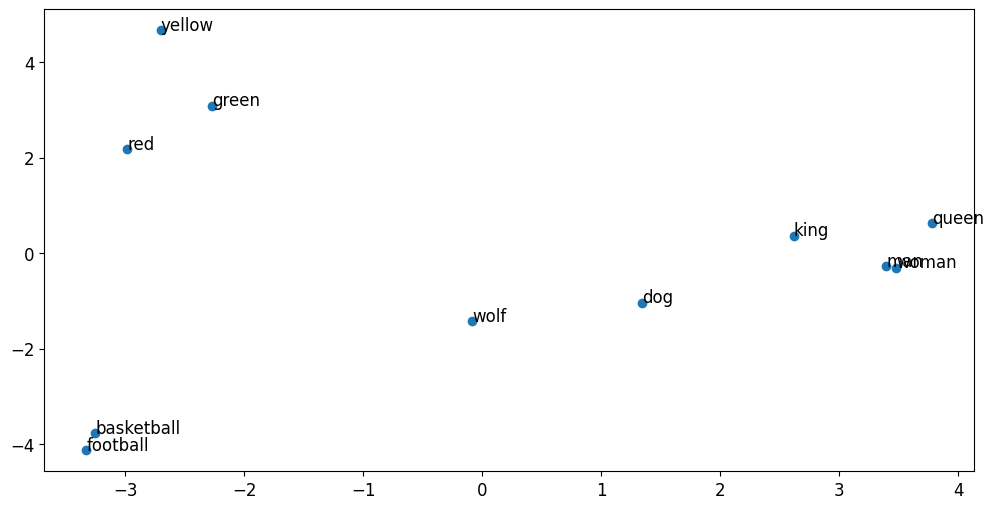

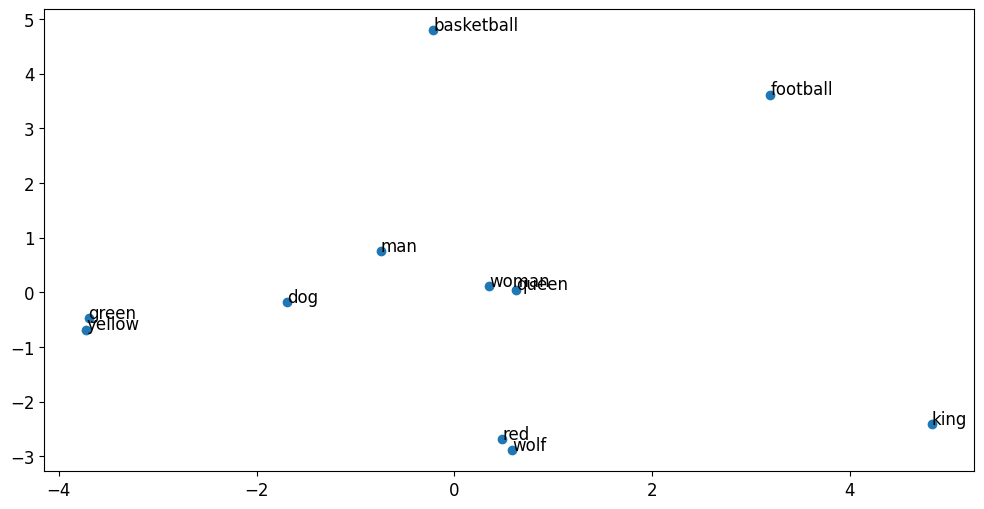

In [86]:
embedding2 = embedding * 1. + pos_encoding[:,:,:] * 1.

plot_words(embedding2, sequences, 0)
plot_words(embedding2, sequences, 1)
texts

Wow look at the big difference between the plots! Both plots have changed drastically compared to their original counterparts. Notice that in the second image, which corresponds to the sentence in which similar words are not together, very dissimilar words such as `red` and `wolf` appear more close.

Now you can try different relative weights and see how this strongly impacts the vector representation of the words in the sentence.

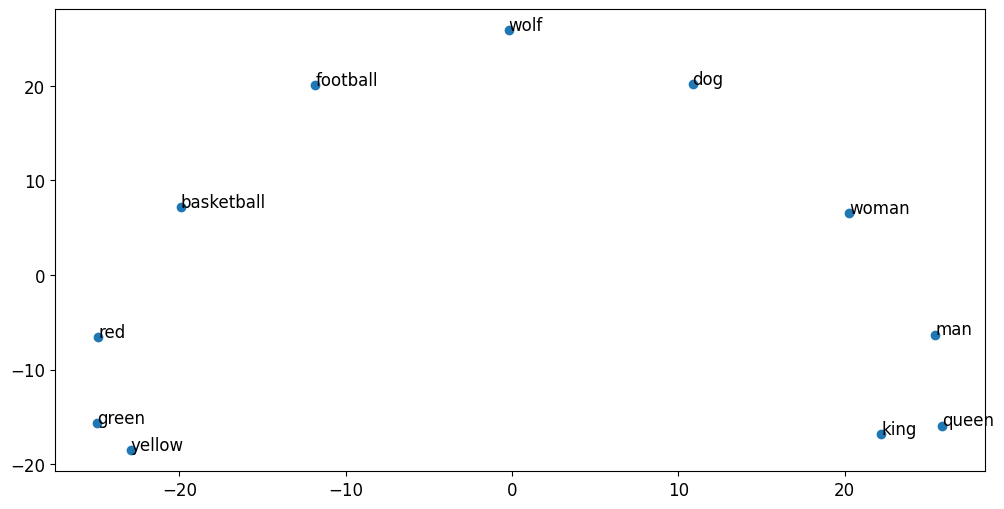

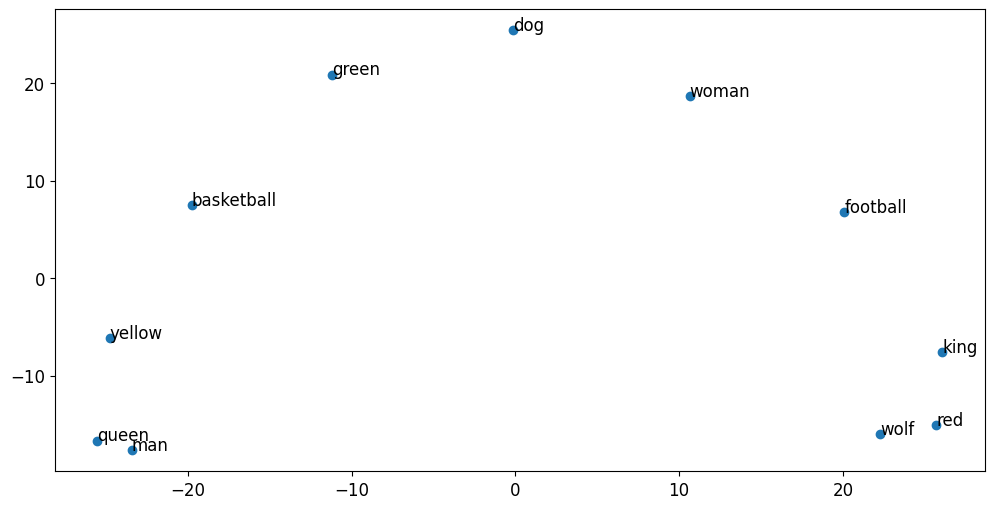

In [45]:
W1 = 1 # Change me
W2 = 10 # Change me
embedding2 = embedding * W1 + pos_encoding[:,:,:] * W2
plot_words(embedding2, sequences, 0)
plot_words(embedding2, sequences, 1)

# For reference
#['king queen man woman dog wolf football basketball red green yellow',
# 'man queen yellow basketball green dog  woman football  king red wolf']

If you set `W1 = 1` and `W2 = 10`, you can see how arrangement of the words begins to take on a clockwise or anti-clockwise order depending on the position of the words in the sentence. Under these parameters, the positional encoding vectors have dominated the embedding. 

Now try inverting the weights to `W1 = 10` and `W2 = 1`. Observe that under these parameters, the plot resembles the original embedding visualizations and there are only a few changes between the positions of the plotted words.

In the previous Transformer assignment, the word embedding is multiplied by `sqrt(EMBEDDING_DIM)`. In this case, it will be equivalent using `W1 = sqrt(EMBEDDING_DIM) = 10` and `W2 = 1`. 

### Congratulations!
 
You've completed this notebook, and have a better sense of the inputs of the Transformer network! 

By now, you've: 

* Created positional encoding matrices to visualize the relational properties of the vectors
* Plotted embeddings and positional encodings on a Cartesian plane to observe how they affect each other 


<font color='blue'><b>What you should remember</b>:
- Positional encodings can be expressed as linear functions of each other, which allow the model to learn according to the relative positions of words.
- Positional encodings can affect the word embeddings, but if the relative weight of the positional encoding is small, the sum will retain the semantic meaning of the words.  
